# Comparing new COVID-19 cases between the US and Germany
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/SARS-CoV-2_without_background.png/597px-SARS-CoV-2_without_background.png" alt="the coronavirus" width="100" style="float:left"/>

In [20]:
from covidutils import *

In [21]:
%matplotlib notebook
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ipywidgets as widgets

## Load all the most up to date data

- Germany: Robert Koch-Institut; Bundesamt für Kartographie und Geodäsie
- USA: New York Times, US Census Bureau

In [22]:
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
df_nyt = pd.read_csv(url)
print('--> Loaded newest COVID-19 data for the US from the New York Times.')

url = "https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data"
df_rki = pd.read_csv(url)
print('--> Loaded newest COVID-19 data for Germany from the Robert-Koch-Institut.')

df_blpop = pd.read_csv('data/RKI_Corona_Bundeslander.csv')
# url = 'https://opendata.arcgis.com/datasets/ef4b445a53c1406892257fe63129a8ea_0.csv'
# df_blpop = pd.read_csv(url)
# print('--> Loaded population data for German states from the Robert-Koch-Institut.')

df_lkpop = pd.read_csv('data/RKI_Corona_Landkreise.csv')
# url = 'https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0.csv'
# df_lkpop = pd.read_csv(url)
# print('--> Loaded population data for German counties from the Robert-Koch-Institut.')

df_uspop = pd.read_csv('data/co-est2019-alldata.csv', encoding = "ISO-8859-1", engine='python')
# url = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv'
# df_uspop =  pd.read_csv(url, encoding = "ISO-8859-1", engine='python')
# print('--> Loaded population data for US states and counties from the US Census Bureau.')

url = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
df_policy = pd.read_csv(url)
print('--> Loaded government response data from Oxford Blavatnik School of Government.')

--> Loaded newest COVID-19 data for the US from the New York Times.
--> Loaded newest COVID-19 data for Germany from the Robert-Koch-Institut.
--> Loaded government response data from Oxford Blavatnik School of Government.


/home/parndt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Set regions to compare

In [23]:
state = "California"
county = "San Diego"
# county = "Los Angeles"
bundesland = "Bayern"
landkreis = "LK Fürstenfeldbruck"

In [24]:
# landkreis = 'SK Freiburg i.Breisgau'
# bundesland = 'Baden-Württemberg'

## get population data

In [25]:
einwohner_bl = dict(zip(df_blpop['LAN_ew_GEN'], df_blpop['LAN_ew_EWZ']))
einwohner_lk = dict(zip(df_lkpop['county'], df_lkpop['EWZ']))
pop_de = np.sum(list(einwohner_bl.values()))
pop_bl = einwohner_bl[bundesland]
pop_lk = einwohner_lk[landkreis]
pop_us = np.sum(df_uspop[df_uspop.SUMLEV==40]['POPESTIMATE2019'])
pop_state = np.int64(df_uspop[df_uspop.CTYNAME==state]['POPESTIMATE2019'])[0]
pop_county = np.int64(df_uspop[[county in c for c in df_uspop.CTYNAME]]['POPESTIMATE2019'])[0]
keys = ['USA', state, county, 'Germany', bundesland, landkreis]
vals = [pop_us, pop_state, pop_county, pop_de, pop_bl, pop_lk]
pop = dict(zip(keys,vals))
for k in pop:
    print('population ', k, ': ', pop[k]/1e6, ' million', sep='')

population USA: 328.239523 million
population California: 39.512223 million
population San Diego: 3.33833 million
population Germany: 83.019213 million
population Bayern: 13.076721 million
population LK Fürstenfeldbruck: 0.21932 million


## Process government response data

In [26]:
df_us_policy = df_policy[df_policy.CountryCode.eq('USA')]
df_us_policy = df_us_policy[df_us_policy.RegionName.eq(state)]
df_de_policy = df_policy[df_policy.CountryCode.eq('DEU')]
for df in [df_us_policy, df_de_policy]:
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

/home/parndt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Process Robert Koch Insitut (RKI) data for Germany

In [27]:
df_rki['Meldedatum'] = pd.to_datetime(df_rki['Meldedatum'], format='%Y/%m/%d %H:%M:%S')
df_rki['new_cases'] = [a if n in [0,1] else 0 for (a,n) in zip(df_rki['AnzahlFall'],df_rki['NeuerFall'])]
df_de = df_rki.groupby(['Meldedatum']).sum()
df_bl = df_rki[df_rki.Bundesland.eq(bundesland)].groupby(['Meldedatum']).sum()
df_lk = df_rki[df_rki.Landkreis.eq(landkreis)].groupby(['Meldedatum']).sum()

## Process New York Times (NYT) data for the United States

In [28]:
df_nyt['date'] = pd.to_datetime(df_nyt.date, format='%Y-%m-%d')
df_us = df_nyt.groupby(['date']).sum()
df_us['new_cases'] = np.diff(np.hstack((0,df_us.cases)))
df_state = df_nyt[df_nyt.state.eq(state)].groupby(['date']).sum()
df_state['new_cases'] = np.diff(np.hstack((0,df_state.cases)))
df_county = df_nyt[df_nyt.county.eq(county)].groupby(['date']).sum()
df_county['new_cases'] = np.diff(np.hstack((0,df_county['cases'])))

## calculate per capita new cases

In [29]:
dfs = [df_us, df_state, df_county, df_de, df_bl, df_lk]
min_date = pd.to_datetime('2020-01-15', format='%Y/%m/%d')
max_date = min_date
# idx = pd.date_range('09-01-2013', '09-30-2013')
for i, df in enumerate(dfs):
    this_pop = list(pop.values())[i]
    df['new_cases_per_1e5'] = df.new_cases / this_pop * 1e5
    df['new_cases_per_1e5'] = np.clip(df['new_cases_per_1e5'],0,np.inf)
    mt = np.max(df.index)
    if mt > max_date:
        max_date = mt
idx = pd.date_range(min_date,max_date)
for i, df in enumerate(dfs):
    dfs[i] = df.reindex(idx, fill_value=0)

## plot all together

<IPython.core.display.Javascript object>


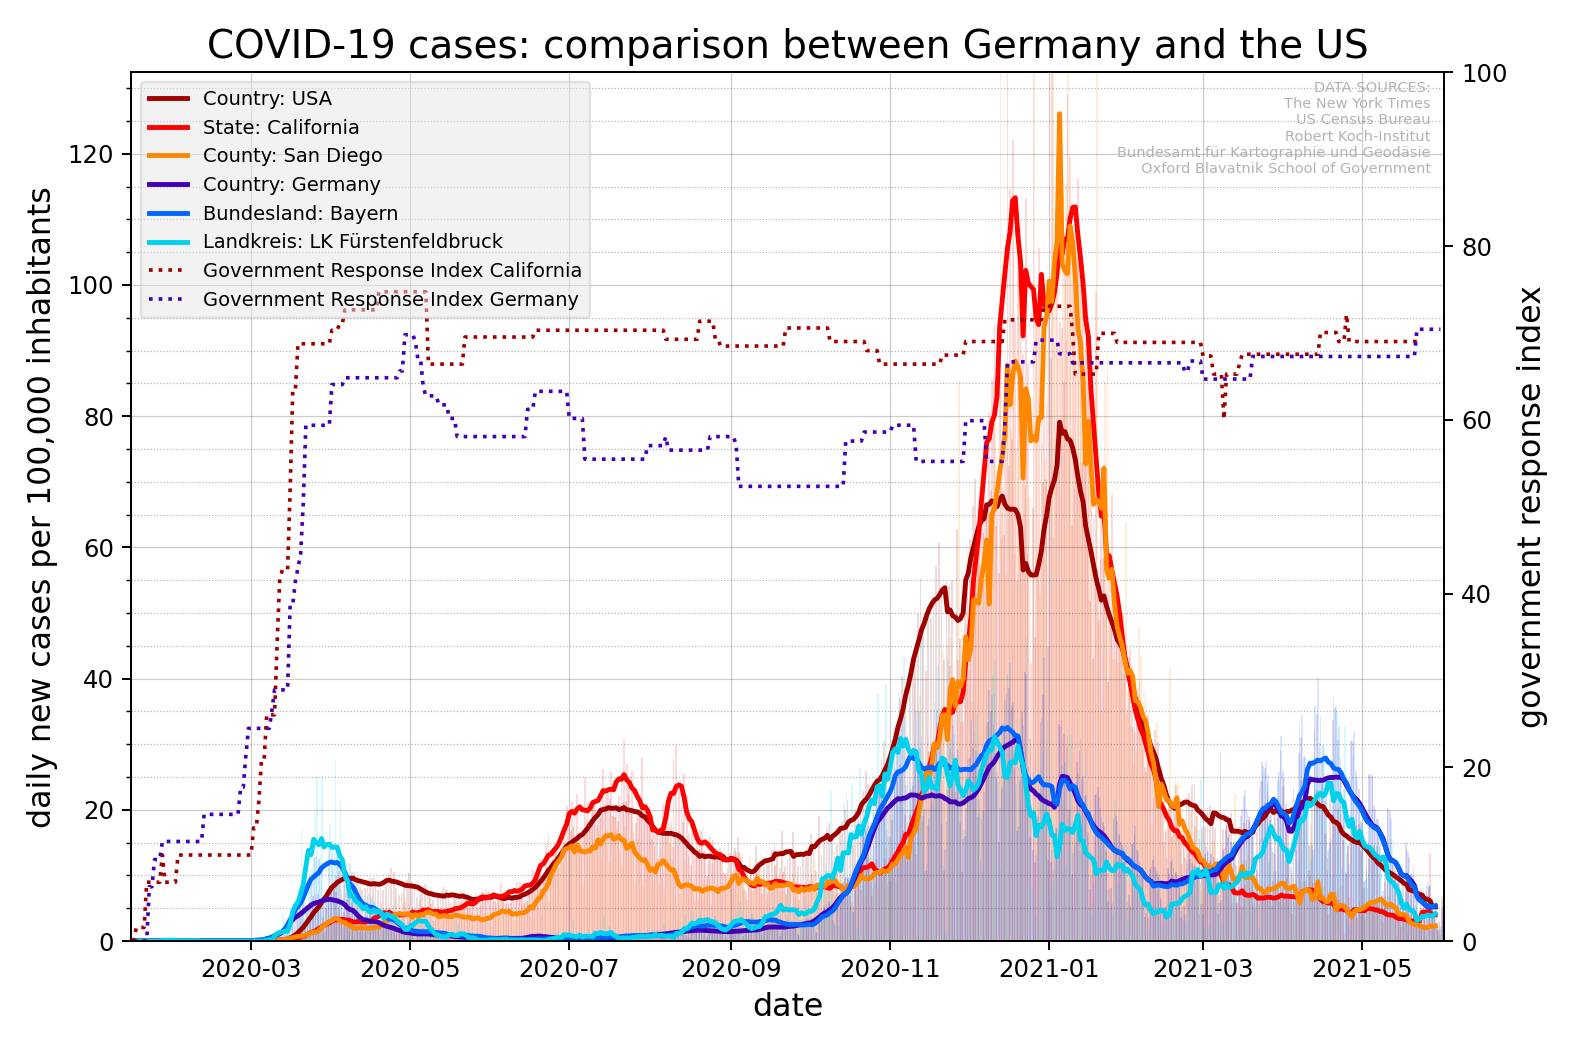

In [30]:
labels = ['Country: ', 'State: ', 'County: ', 'Country: ', 'Bundesland: ','Landkreis: ']
colvals = [[158, 0, 0], [255, 0, 0], [255, 136, 0], [65, 0, 179], [0, 102, 255], [0, 209, 237]]
colvals = [tuple(np.array(x)/255) for x in colvals]

fig = plt.figure(figsize=[9, 6])
ax = fig.add_subplot(111)
width = 2/3
for i, df in enumerate(dfs):
    j = (i % 3) - 1
    ax.bar(df.index + timedelta(days=j*width/2),df.new_cases_per_1e5,width,color=colvals[i],alpha=0.15)

ax2 = ax.twinx()
polus, = ax2.plot(df_us_policy['Date'],df_us_policy['GovernmentResponseIndex'],c=colvals[0],ls=':',label='Government Response Index California')
polde, = ax2.plot(df_de_policy['Date'],df_de_policy['GovernmentResponseIndex'],c=colvals[3],ls=':',label='Government Response Index Germany')

handles = []
maxy = 0
for i, df in enumerate(dfs):
    region = list(pop.keys())[i]
    if (i<3) and (df.new_cases_per_1e5[-1] == 0):
        df.new_cases_per_1e5[-1] = np.nan
    ln = df.new_cases_per_1e5.rolling(window=7,center=True).mean()
    maxy = np.max((maxy, np.max(ln)))
#     ln[-1] = df.new_cases_per_1e5[-1]
#     ln[-2] = np.nanmean(df.new_cases_per_1e5[-2:])
#     ln[-3] = np.nanmean(df.new_cases_per_1e5[-3:])
    p, = ax.plot(ln,c=colvals[i],lw=2,label=labels[i]+region)
    handles.append(p)
ax.set_title('COVID-19 cases: comparison between Germany and the US',fontsize=16)
ax.set_xlim((min_date,max_date+timedelta(days=1/3)))
ax.set_ylim((0,maxy*1.05))
ax.set_xlabel('date',fontsize=13)
ax.set_ylabel('daily new cases per 100,000 inhabitants',fontsize=13)
ax2.set_ylabel('government response index',fontsize=13)
desc = 'DATA SOURCES:\nThe New York Times\nUS Census Bureau\nRobert Koch-Institut\nBundesamt für Kartographie und Geodäsie\nOxford Blavatnik School of Government'
ax2.text(0.99, 0.99, desc, horizontalalignment='right', verticalalignment='top', 
        transform=ax.transAxes,fontsize=6,color=(0.7,0.7,0.7))
handles.append(polus)
handles.append(polde)
lgd1 = ax.legend(handles=handles,loc='upper left',facecolor=(0.9,0.9,0.9),framealpha=0.5,fontsize=8)
lgd1.remove()
ax2.add_artist(lgd1)
ax2.set_ylim((0,100))
ax.grid(b=True,which='major',ls='-',c='k',lw=0.5,alpha=0.2)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
ax.grid(b=True,which='minor',axis='y',ls=':',c='k',lw=0.5,alpha=0.3)
plt.tight_layout()

## Individual plots

<IPython.core.display.Javascript object>


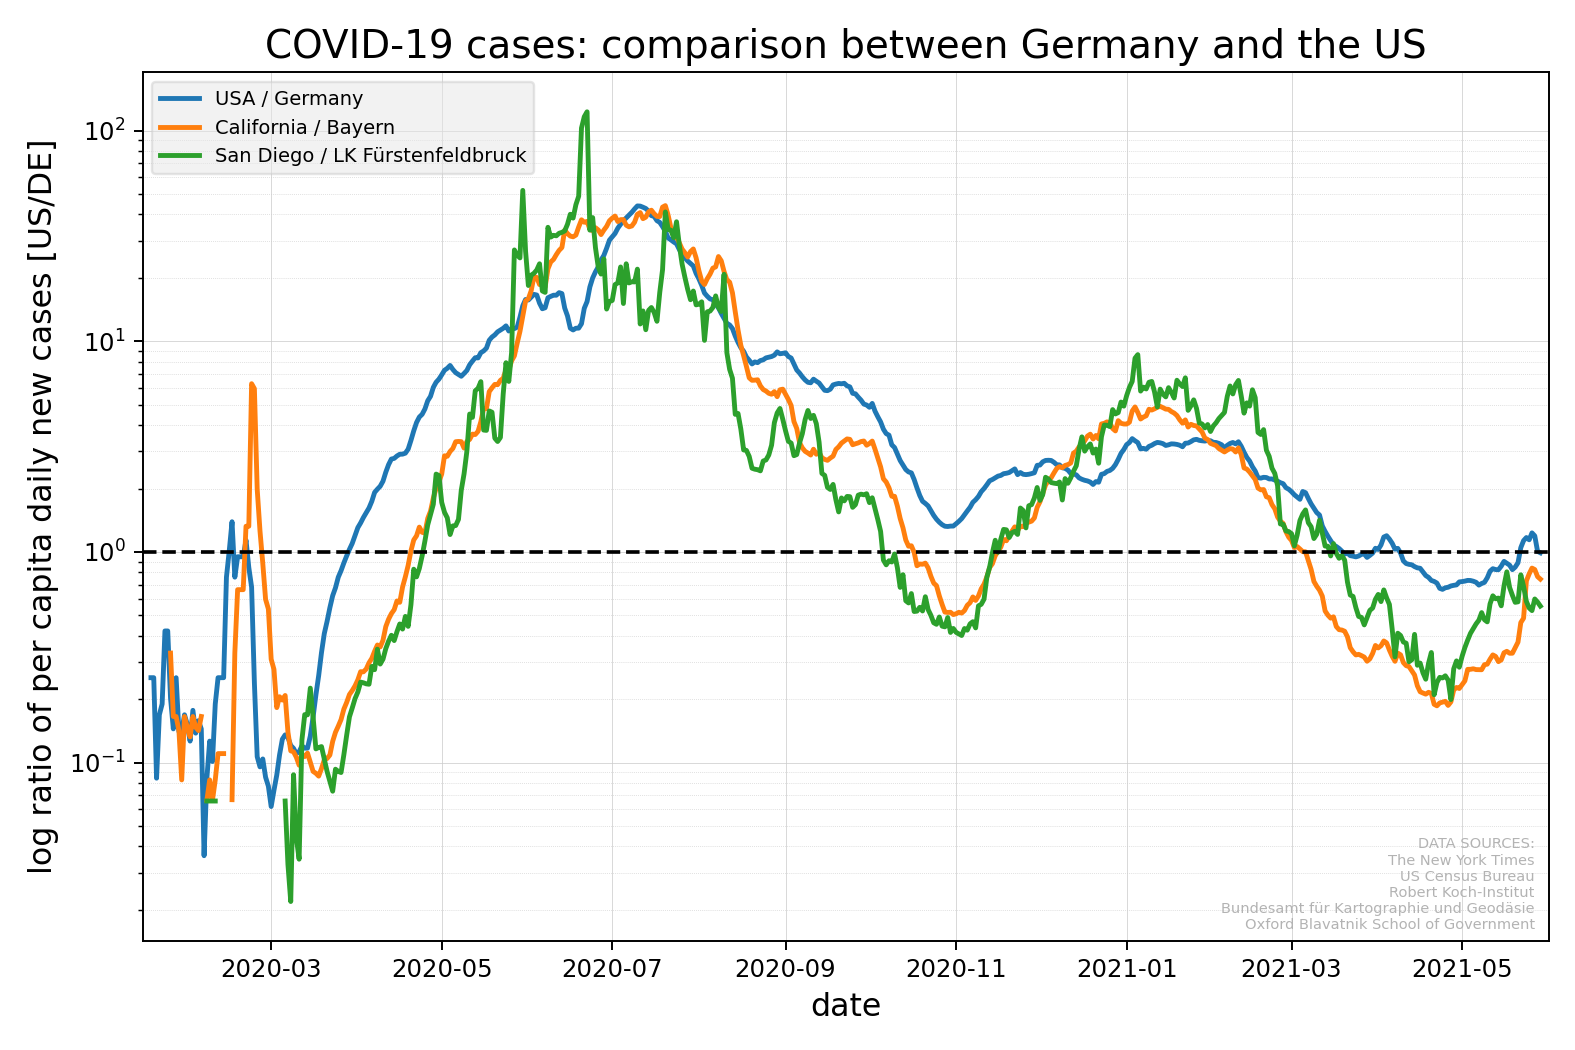

/home/parndt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
fig = plt.figure(figsize=[9, 6])
ax = fig.add_subplot(111)
handles = []
for i in range(3):
    df_usa = dfs[i]
    df_deu = dfs[3+i]
    region_usa = list(pop.keys())[i]
    region_deu = list(pop.keys())[3+i]
    if df_usa.new_cases_per_1e5[-1] == 0:
        df_usa.new_cases_per_1e5[-1] = np.nan
    if df_deu.new_cases_per_1e5[-1] == 0:
        df_deu.new_cases_per_1e5[-1] = np.nan
    ln = (df_usa.new_cases_per_1e5.rolling(window=7,center=True).mean() / 
          df_deu.new_cases_per_1e5.rolling(window=7,center=True).mean())
    ln[np.log10(ln)<-10] = np.nan
    p, = ax.plot(ln,lw=2,label=region_usa + ' / ' + region_deu)
    handles.append(p)
ax.plot((min_date,max_date),(1,1),'k--')
ax.set_title('COVID-19 cases: comparison between Germany and the US',fontsize=16)
ax.set_xlim((min_date,max_date))
ax.set_xlabel('date',fontsize=13)
ax.set_ylabel('log ratio of per capita daily new cases [US/DE]',fontsize=13)
desc = 'DATA SOURCES:\nThe New York Times\nUS Census Bureau\nRobert Koch-Institut\nBundesamt für Kartographie und Geodäsie\nOxford Blavatnik School of Government'
ax.text(0.99, 0.01, desc, horizontalalignment='right', verticalalignment='bottom', 
        transform=ax.transAxes,fontsize=6,color=(0.7,0.7,0.7))
ax.set_yscale('log')
plt.grid(b=True, which='major', color=(0.8,0.8,0.8), linestyle='-',linewidth=0.3)
plt.grid(b=True, which='minor', color=(0.8,0.8,0.8), linestyle=':',linewidth=0.3)
lgd1 = ax.legend(handles=handles,loc='upper left',facecolor=(0.9,0.9,0.9),framealpha=0.5,fontsize=8)
plt.tight_layout()

<IPython.core.display.Javascript object>


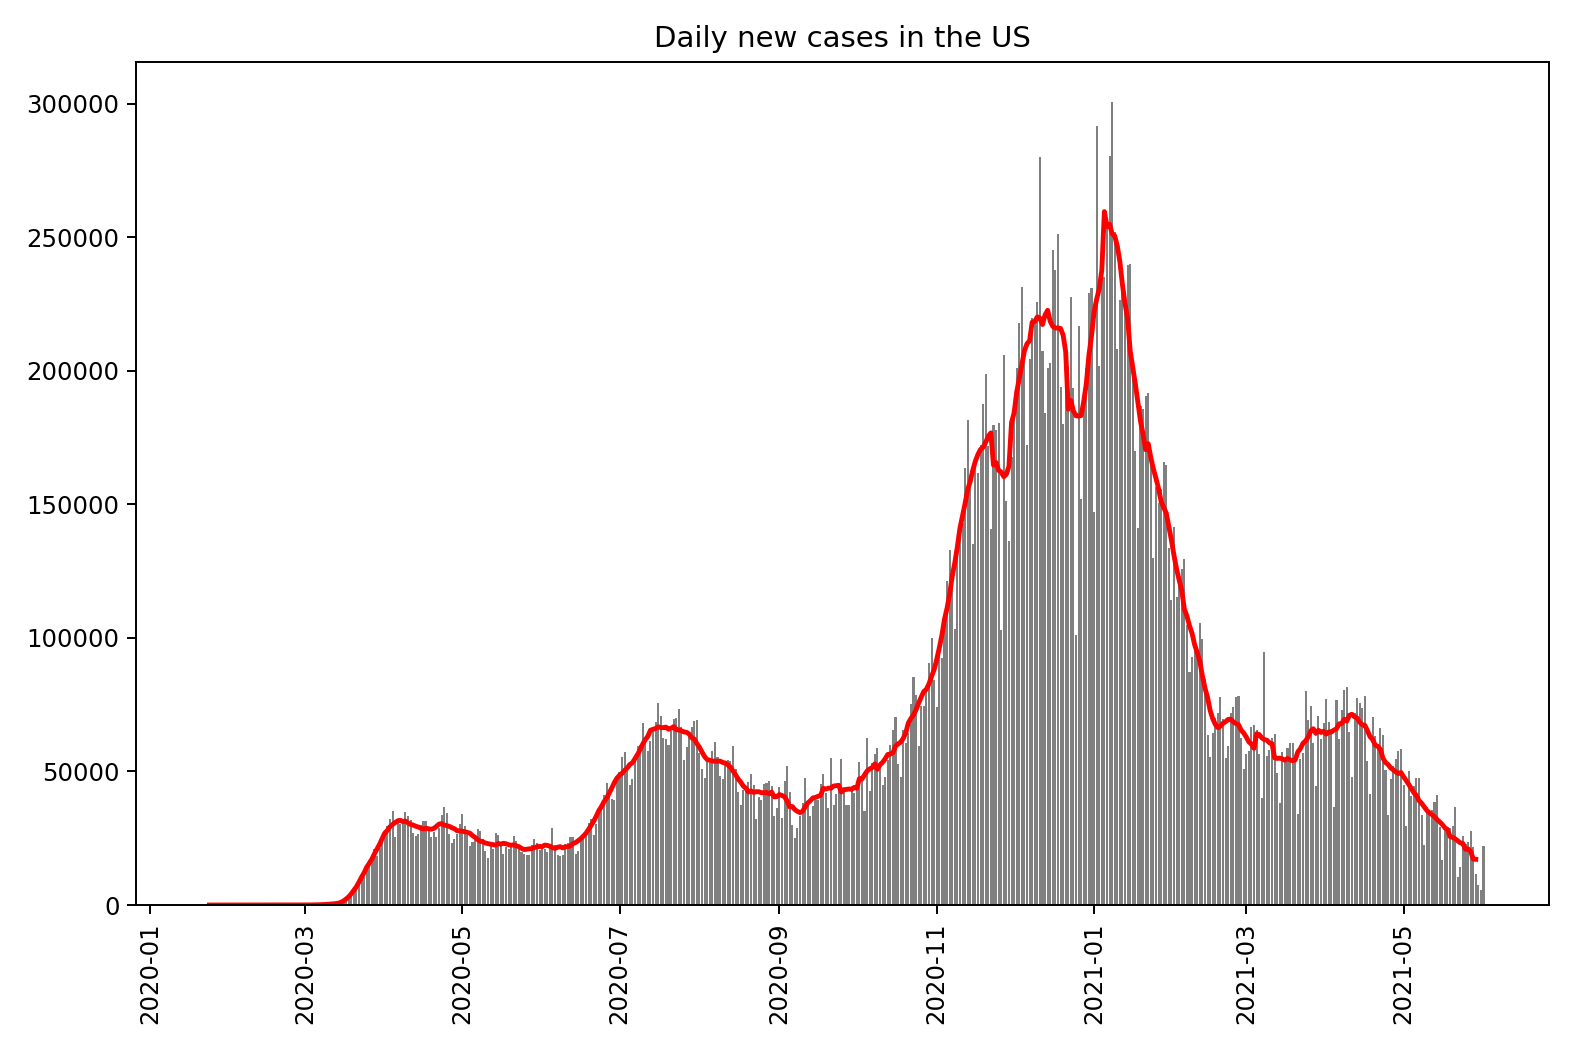

In [32]:
fig = plt.figure(figsize=[9, 6])
ax = fig.add_subplot(111)
ax.bar(df_us.index,df_us.new_cases,color='gray')
ax.plot(df_us.new_cases.rolling(window=7,center=True).mean(),c='red',lw=2)
ax.set_title('Daily new cases in the US')
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


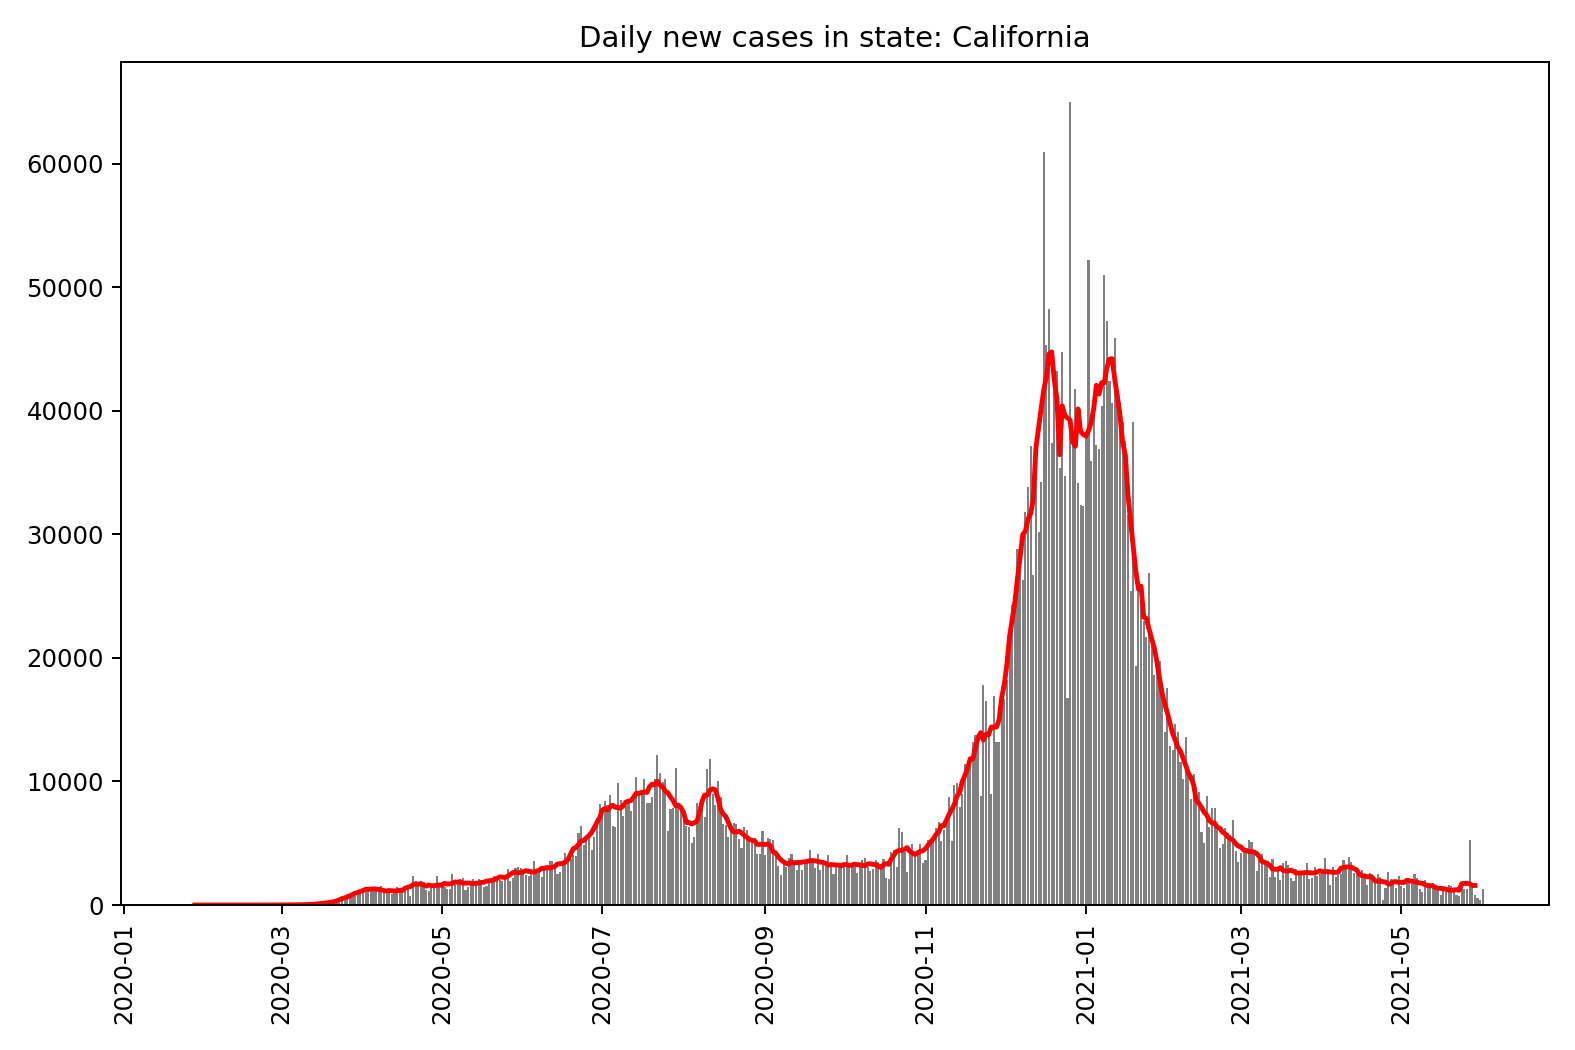

In [33]:
fig = plt.figure(figsize=[9, 6])
ax = fig.add_subplot(111)
ax.bar(df_state.index,df_state.new_cases,color='gray')
ax.plot(df_state.new_cases.rolling(window=7,center=True).mean(),c='red',lw=2)
ax.set_title('Daily new cases in state: %s' % state)
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


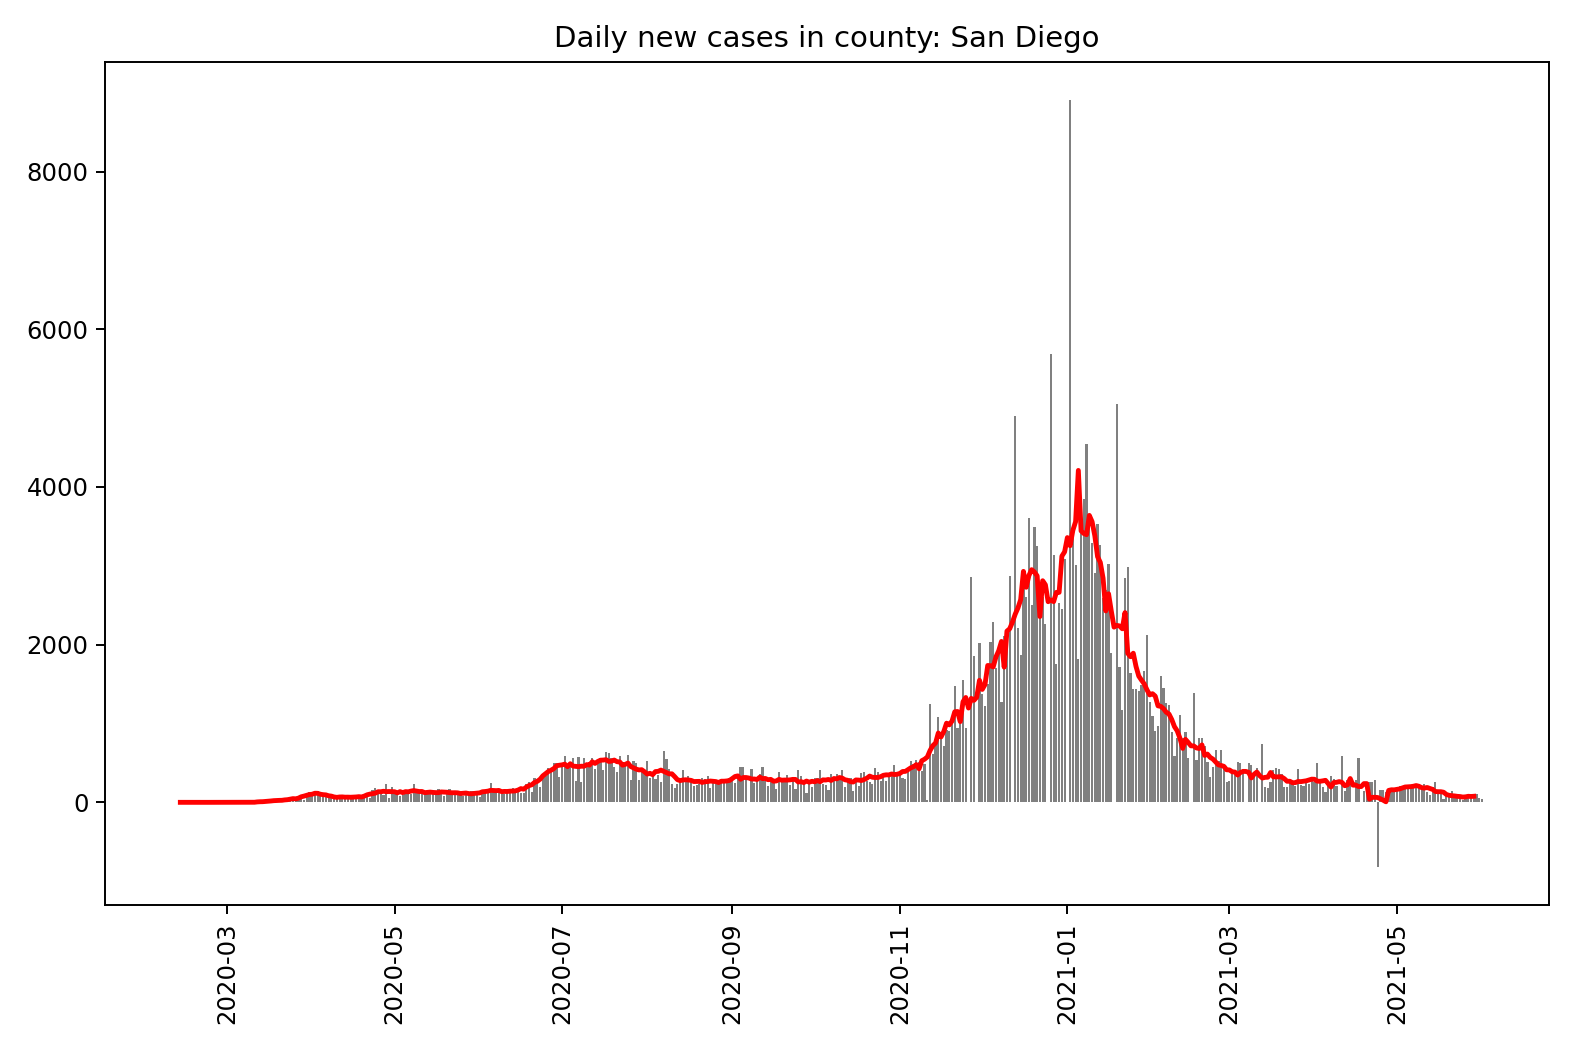

In [34]:
fig = plt.figure(figsize=[9, 6])
ax = fig.add_subplot(111)
ax.bar(df_county.index,df_county.new_cases,color='gray')
ax.plot(df_county.new_cases.rolling(window=7,center=True).mean(),c='red',lw=2)
ax.set_title('Daily new cases in county: %s' % county)
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


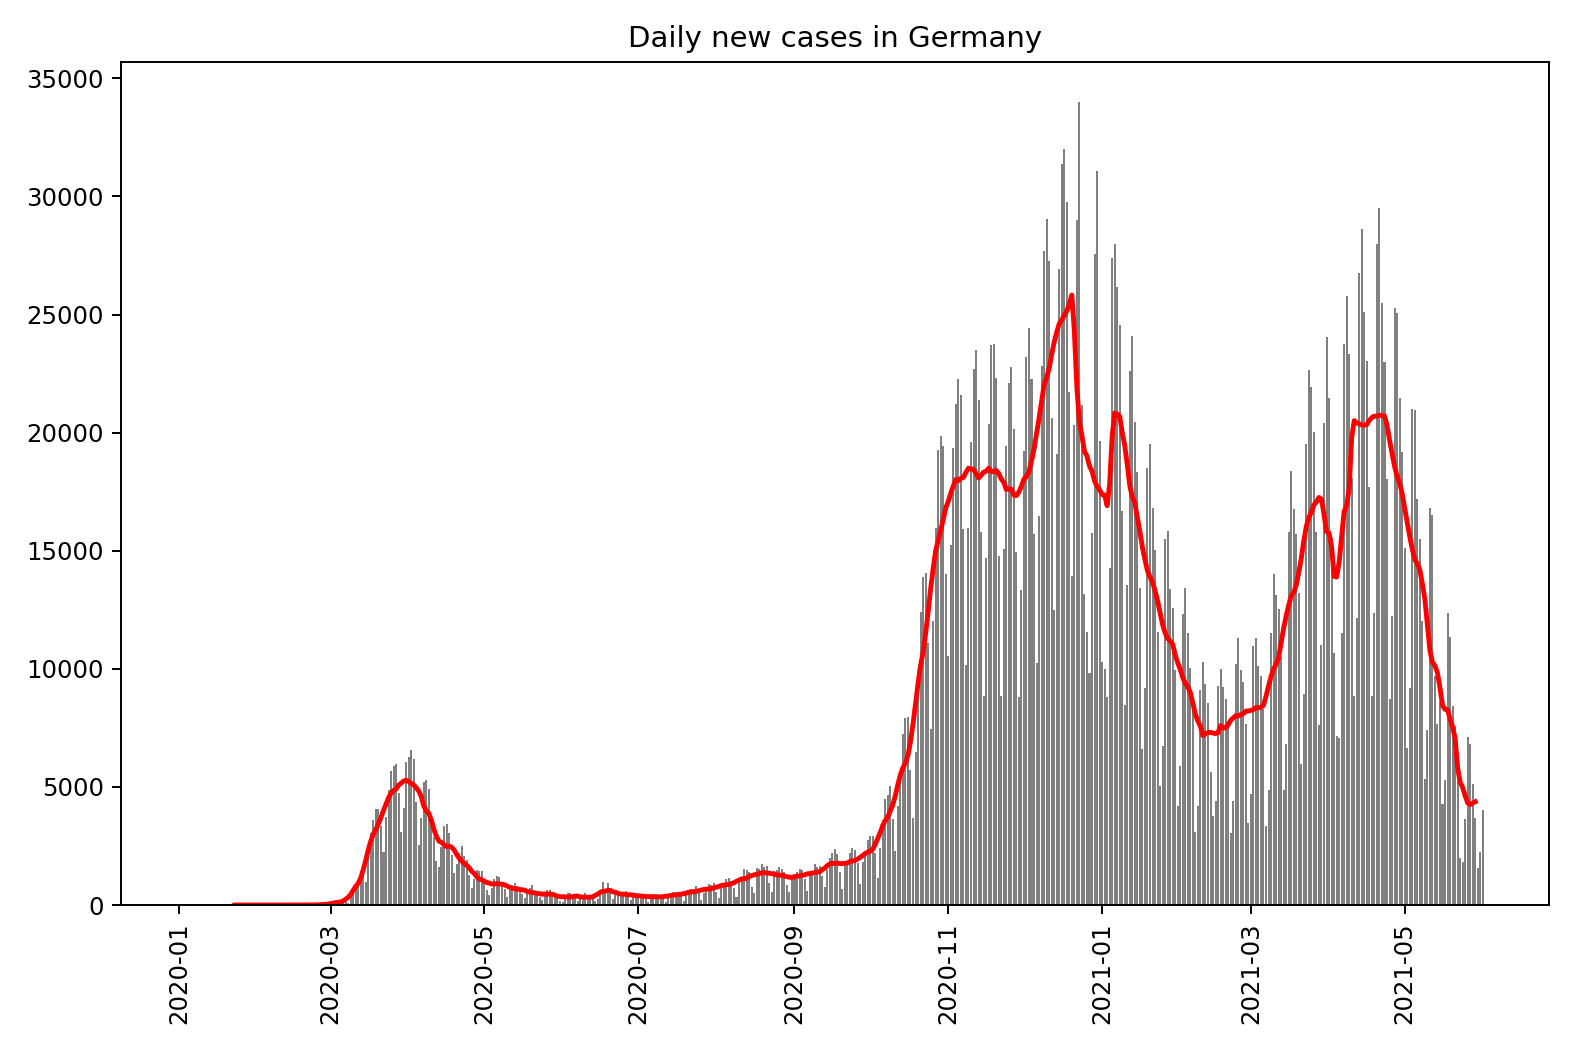

In [35]:
fig = plt.figure(figsize=[9, 6])
ax = fig.add_subplot(111)
ax.bar(df_de.index,df_de.new_cases,color='gray')
ax.plot(df_de.new_cases.rolling(window=7,center=True).mean(),c='red',lw=2)
ax.set_title('Daily new cases in Germany')
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


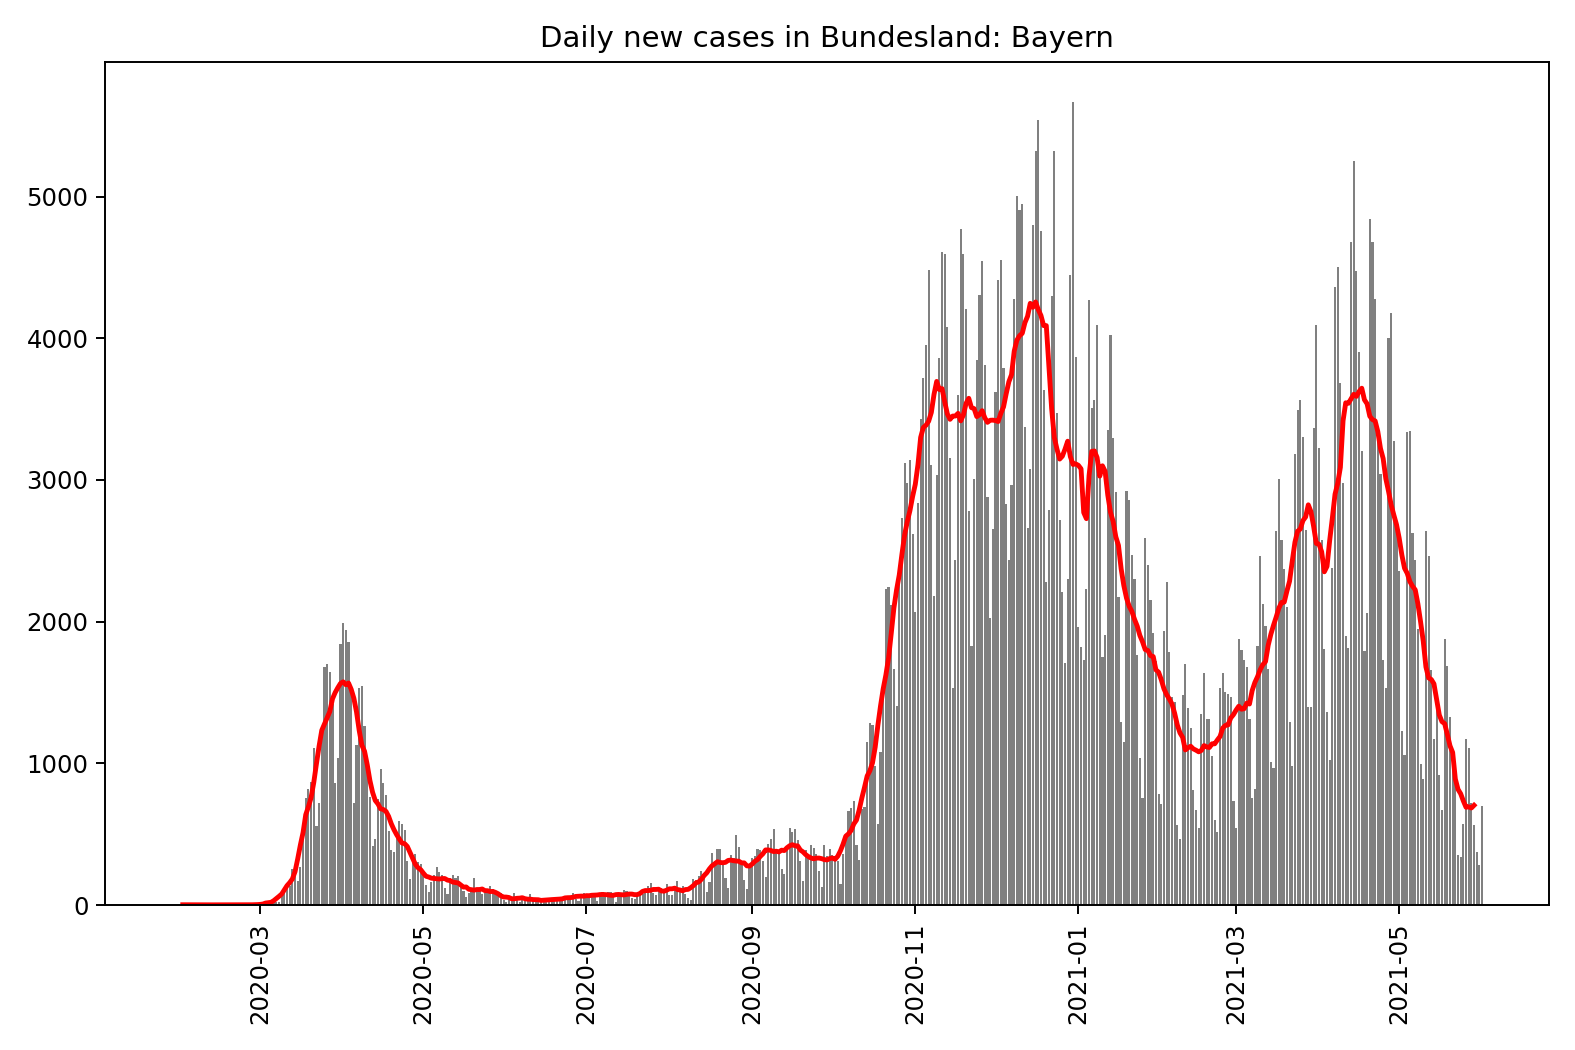

In [36]:
fig = plt.figure(figsize=[9, 6])
ax = fig.add_subplot(111)
ax.bar(df_bl.index,df_bl.new_cases,color='gray')
ax.plot(df_bl.new_cases.rolling(window=7,center=True).mean(),c='red',lw=2)
ax.set_title('Daily new cases in Bundesland: %s' % bundesland)
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


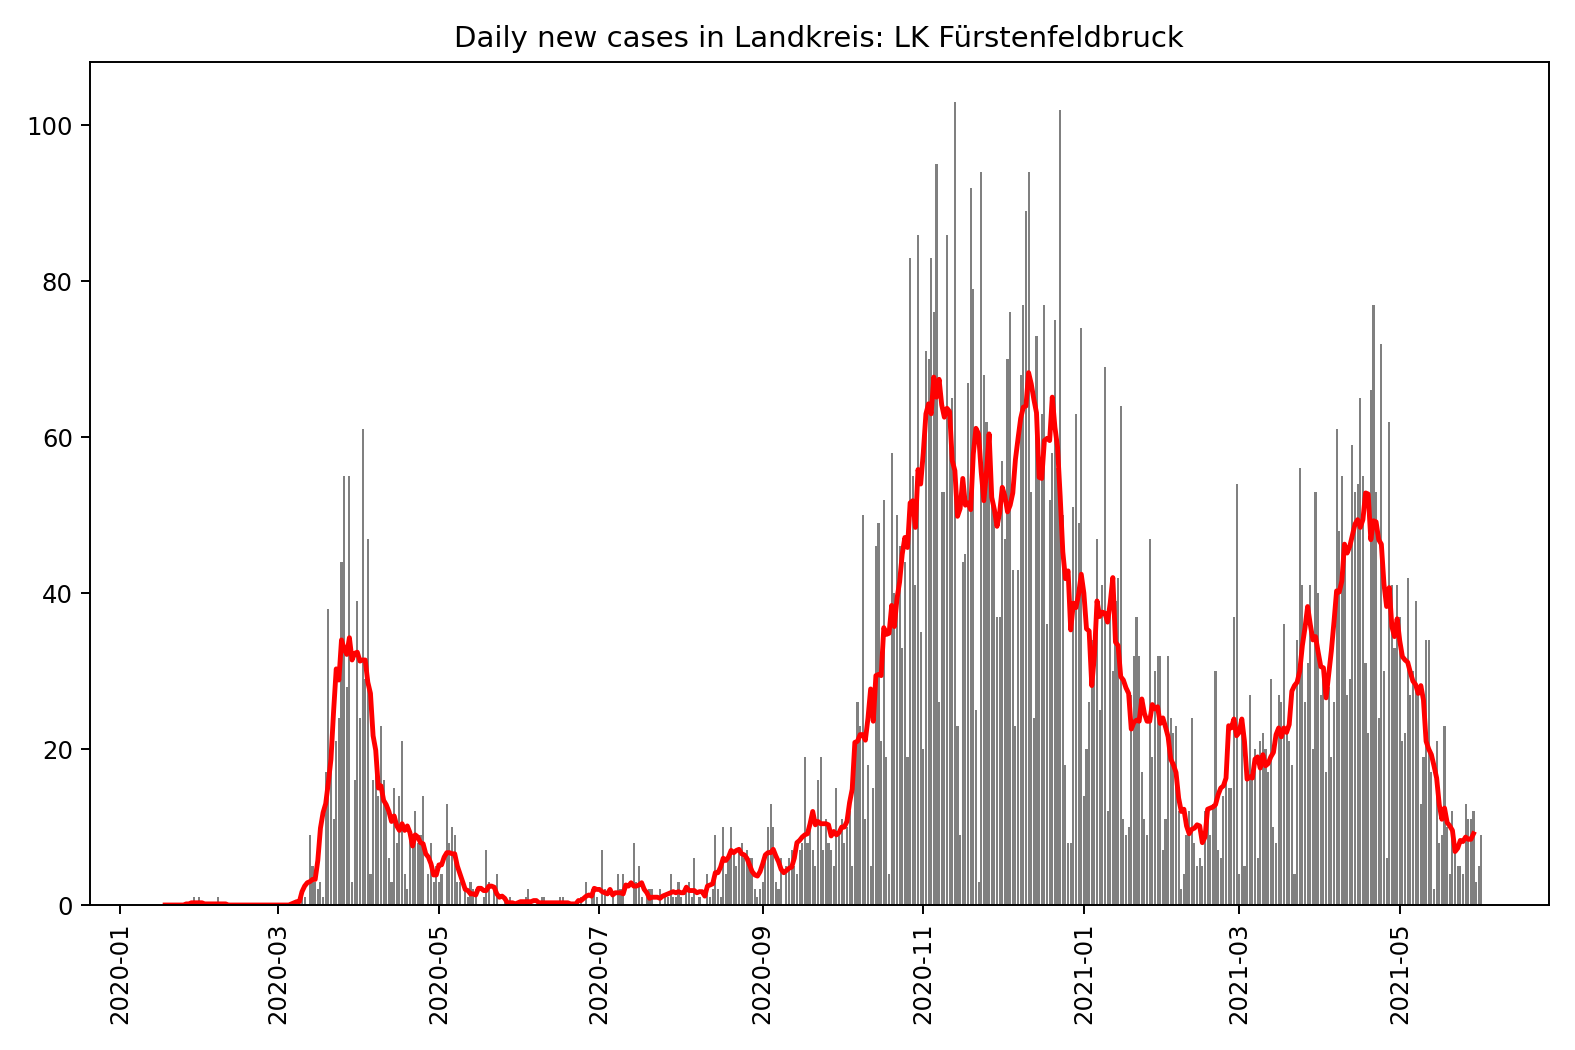

In [37]:
fig = plt.figure(figsize=[9, 6])
ax = fig.add_subplot(111)
df = dfs[-1]
ax.bar(df.index,df.new_cases,color='gray')
ax.plot(df.new_cases.rolling(window=7,center=True).mean(),c='red',lw=2)
ax.set_title('Daily new cases in Landkreis: %s' % landkreis)
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


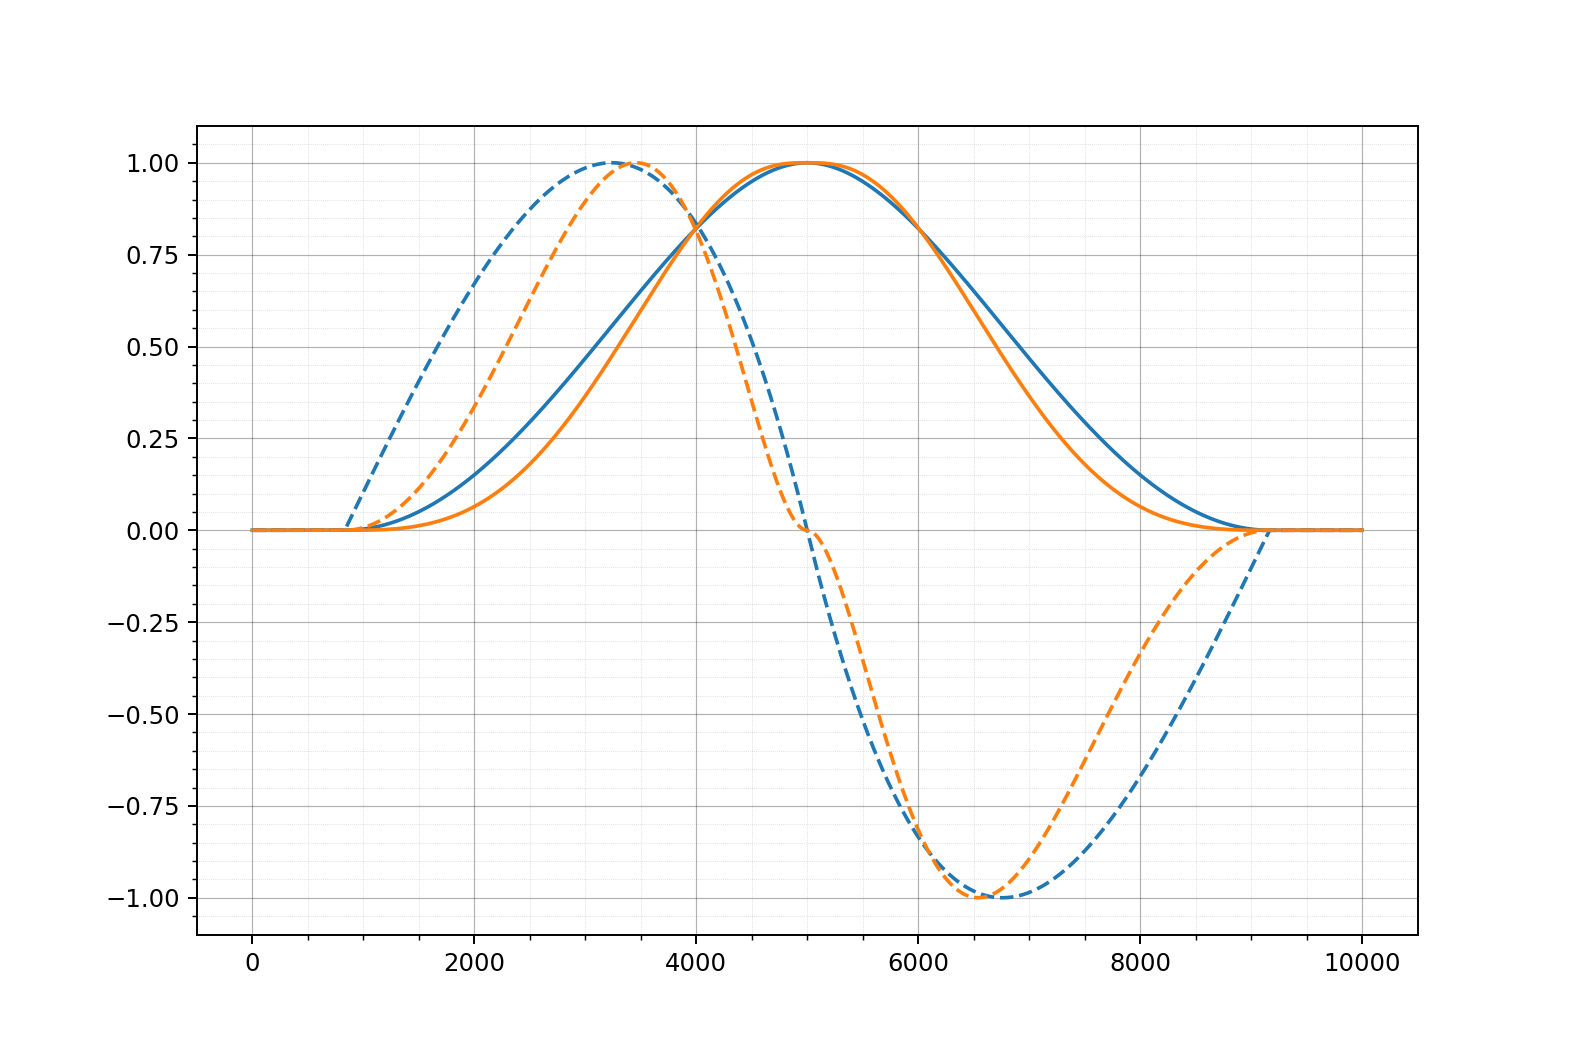

In [38]:
md = 3
ex = 2
x = np.clip(np.linspace(-1.2*md,1.2*md,10000),-md,md)
y = (1-(np.abs(x)/md)**ex)**ex
y = 1-(1-(1-np.abs(x)/md)**ex)**ex
ex = 3
y2 = 1-(1-(1-np.abs(x)/md)**ex)**ex
#y = 1-(1-((1-x)/md)**3)**3
yd = np.diff(y)
yd2 = np.diff(y2)

fig = plt.figure(figsize=[9, 6])
ax = fig.add_subplot(111)
ax.plot(y,'-',c='C0')
ax.plot(y2,'-',c='C1')
ax.plot(yd/np.max(yd),'--',c='C0')
ax.plot(yd2/np.max(yd2),'--',c='C1')
plt.grid(b=True,which='major',ls='-',c='k',lw=0.5,alpha=0.3)
plt.minorticks_on()
plt.grid(b=True,which='minor',ls=':',c='k',lw=0.3,alpha=0.2)